In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

2025-11-10 05:03:01.349432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762750981.386237     421 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762750981.397679     421 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
data_dir = "/kaggle/input/isic-2020-jpg-256x256-resized"
csv_path = os.path.join(data_dir, "train-metadata.csv")
df = pd.read_csv(csv_path)

print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df["target"].value_counts())

Dataset shape: (33126, 4)

Class distribution:
target
0    32542
1      584
Name: count, dtype: int64


In [3]:
df["image_path"] = df["isic_id"].apply(
    lambda x: os.path.join(data_dir, "train-image", "image", f"{x}.jpg")
)

In [4]:
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["target"], random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 26500
Validation samples: 6626


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_df['target_str'] = train_df['target'].astype(str)
val_df['target_str'] = val_df['target'].astype(str)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="target_str",
    target_size=IMG_SIZE,
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="target_str",
    target_size=IMG_SIZE,
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 26500 validated image filenames belonging to 2 classes.
Found 6626 validated image filenames belonging to 2 classes.


In [6]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

I0000 00:00:1762751014.099138     421 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762751014.099820     421 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2
    )
]

In [8]:
class_weights = {0: 1.0, 1: 2.5}

In [9]:
EPOCHS = 5

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1762751020.549434     475 service.cc:148] XLA service 0x78253800ecf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762751020.549475     475 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762751020.549479     475 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762751020.909312     475 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/829 ━━━━━━━━━━━━━━━━━━━━ 3:44:42 16s/step - accuracy: 0.5312 - auc: 0.0000e+00 - loss: 0.7502

I0000 00:00:1762751034.900799     475 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


829/829 ━━━━━━━━━━━━━━━━━━━━ 401s 465ms/step - accuracy: 0.9728 - auc: 0.4992 - loss: 0.2187 - val_accuracy: 0.9823 - val_auc: 0.7160 - val_loss: 0.0847 - learning_rate: 0.0010
Epoch 2/5
829/829 ━━━━━━━━━━━━━━━━━━━━ 495s 597ms/step - accuracy: 0.9829 - auc: 0.6496 - loss: 0.1715 - val_accuracy: 0.9817 - val_auc: 0.7403 - val_loss: 0.1071 - learning_rate: 0.0010
Epoch 3/5
829/829 ━━━━━━━━━━━━━━━━━━━━ 434s 523ms/step - accuracy: 0.9830 - auc: 0.6704 - loss: 0.1697 - val_accuracy: 0.9823 - val_auc: 0.7441 - val_loss: 0.0830 - learning_rate: 0.0010
Epoch 4/5
829/829 ━━━━━━━━━━━━━━━━━━━━ 354s 426ms/step - accuracy: 0.9829 - auc: 0.7012 - loss: 0.1644 - val_accuracy: 0.9819 - val_auc: 0.7580 - val_loss: 0.1013 - learning_rate: 0.0010
Epoch 5/5
829/829 ━━━━━━━━━━━━━━━━━━━━ 341s 412ms/step - accuracy: 0.9807 - auc: 0.7109 - loss: 0.1768 - val_accuracy: 0.9819 - val_auc: 0.7527 - val_loss: 0.0879 - learning_rate: 0.0010


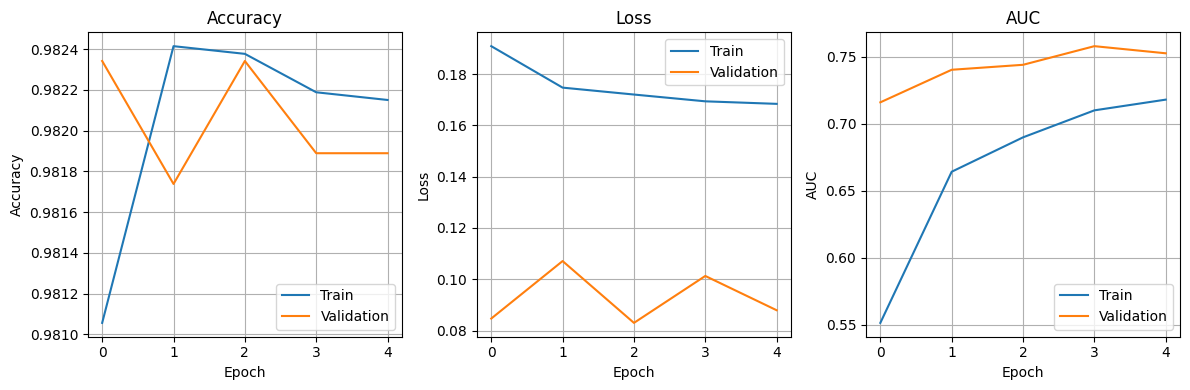

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Validation')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
val_loss, val_acc, val_auc = model.evaluate(val_gen)
print(f"\nValidation Results:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc*100:.2f}%")
print(f"AUC: {val_auc:.4f}")

208/208 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.9814 - auc: 0.7468 - loss: 0.1023

Validation Results:
Loss: 0.1013
Accuracy: 98.19%
AUC: 0.7580


In [ ]:
model.save("skin_cancer_vgg16_model.h5")
print("\nModel saved as 'skin_cancer_vgg16_model.h5'")


Model saved as 'skin_cancer_vgg16_model.h5'
